In [1]:
import numpy as np
import random
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
class Environment:

    def __init__(self):
        self.board = np.zeros((4, 4)).astype(np.uint8)
        i, j = self.random_choice()
        self.board[i][j] = Environment.generate_new()
        self.cul_reward = 0

    def random_choice(self):
        rows, cols = np.where(self.board == 0)
        if len(rows) == 0:
            return None, None
        idx = random.randint(0, len(rows) - 1)
        return rows[idx].item(), cols[idx].item()

    def squeeze(row):
        reward = 0
        if np.sum(row != 0) == 0:
            return row, reward
        # start = np.argmax(row != 0)
        new_row = np.zeros(4)
        set_idx = 0
        start = Environment.find_next_not_zero(row, 0)
        while start is not None and start < len(row):
            next_idx = Environment.find_next_not_zero(row, start + 1)
            if next_idx is None:
                break
            if row[start] == row[next_idx]:
                new_row[set_idx] = row[start] * 2
                reward += new_row[set_idx]
                start = Environment.find_next_not_zero(row, next_idx + 1)
                set_idx += 1
            else:
                new_row[set_idx] = row[start]
                start = Environment.find_next_not_zero(row, next_idx)
                set_idx += 1
        if start is not None and start < len(row):
            new_row[set_idx] = row[start]
        return new_row, float(reward)

    
    def find_next_not_zero(row, idx):
        if idx >= len(row):
            return None
        if row[idx] != 0:
            return idx
        return Environment.find_next_not_zero(row, idx+1)

    def apply_each_row_core(self, row_step, board):
        # print(row_step([4, 4, 0, 0]))
        new_rows = []
        total_rewards = 0
        for row in board:
            # print("row:", row)
            # print("row_step:", row_step(row))
            # print("row_step:", Environment.squeeze(row))
            new_row, reward = row_step(row)
            new_rows.append(new_row)
            total_rewards += reward
        return np.array(new_rows), total_rewards

    def apply_to_each_row(self, row_step):
        return self.apply_each_row_core(row_step, self.board)

    def apply_to_each_col(self, col_step):
        new_board_T, total_rewards = self.apply_each_row_core(col_step, self.board.T)
        return new_board_T.T, total_rewards

    def generate_new():
        return 2 if random.random() < 0.9 else 4

    def reverse_squeeze(row):
        new_row, reward = Environment.squeeze(row[::-1])
        return new_row[::-1], reward

    def move_left(self):
        new_board, reward = self.apply_to_each_row(Environment.squeeze)
        self.board = new_board
        self.cul_reward += reward
        return new_board, reward
        # new_board = np.apply_along_axis(squeeze, axis=1, arr=self.board)
        

    def move_right(self):
        new_board, reward = self.apply_to_each_row(Environment.reverse_squeeze)
        self.board = new_board
        self.cul_reward += reward
        return new_board, reward
        
        # return np.apply_along_axis(reverse_squeeze, axis=1, arr=self.board)

    def move_up(self):
        # return np.apply_along_axis(squeeze, axis=0, arr=self.board)
        new_board, reward = self.apply_to_each_col(Environment.squeeze)
        self.board = new_board
        self.cul_reward += reward
        return new_board, reward

    def move_down(self):
        new_board, reward = self.apply_to_each_col(Environment.reverse_squeeze)
        self.board = new_board
        self.cul_reward += reward
        return new_board, reward
        # return np.apply_along_axis(reverse_squeeze, axis=0, arr=self.board)

    def step(self, action):
        old_board = self.board
        new_board, reward = None, None
        if action == 0:
            new_board, reward = self.move_left()
        elif action == 1:
            new_board, reward = self.move_right()
        elif action == 2:
            new_board, reward = self.move_up()
        elif action == 3:
            new_board, reward = self.move_down()
        else:
            print("wrong action")

        is_done = False
        if np.any(old_board != new_board):
            i, j = self.random_choice()
            self.board[i][j] = Environment.generate_new()
            is_done = self.check_done()
        
        # print(self.board, reward)
        return self.board, reward, is_done


    def check_done(self):
        if np.any(self.board == 0):
            # print("0")
            # print(self.board == 0)
            return False
        for i in range(4):
            for j in range(3):
                if self.board[i][j] == self.board[i][j + 1]:
                    # print("1", i, j)
                    return False
        for i in range(3):
            for j in range(4):
                if self.board[i][j] == self.board[i+1][j]:
                    # print("2", i, j)
                    return False
        return True

    def get_state(self):
        return torch.tensor(self.board.reshape(-1).astype(np.float32))
        
        

    # reverse_squeeze = lambda row: squeeze(row[::-1])[::-1]
    
    # self.move_left = lambda : np.apply_along_axis(squeeze, axis=1, arr=self.board)
    # move_right = lambda : np.apply_along_axis(reverse_squeeze, axis=1, arr=self.board)
    # move_up = lambda : np.apply_along_axis(squeeze, axis=0, arr=self.board)
    # move_down = lambda : np.apply_along_axis(reverse_squeeze, axis=0, arr=self.board)

In [293]:
env.board = np.array([[4, 8, 4, 0], [64, 4, 2, 2], [2, 32, 8, 16], [8, 2, 128, 4]])

In [3]:
env = Environment()
print(env.board)
while True:
    text = input("move?")
    if text == "q" or text not in ['u', 'd', 'l', 'r']:
        break
    a = env.step(text)
    # if np.all(previous_board == board):
        # continue
    # if i is None:
    #     print("failed")
    # else:
    #     board[i][j] = generate_new()

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 0 0]]


move? u
move? u


KeyboardInterrupt: Interrupted by user

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.input_layer = nn.Linear(16, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = torch.log2(x + 1)
        x = F.relu(self.input_layer(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [212]:
q_network(s_batch)

tensor([[78.3949, 83.6609, 80.7947, 87.1520]], grad_fn=<AddmmBackward0>)

In [216]:
s_batch.log2()

tensor([[1., 4., 3., -inf, 2., 1., 5., -inf, 5., 3., 6., -inf, 2., 1., 1., -inf]])

In [220]:
torch.log2(s_batch + 1)

tensor([[1.5850, 4.0875, 3.1699, 0.0000, 2.3219, 1.5850, 5.0444, 0.0000, 5.0444,
         3.1699, 6.0224, 0.0000, 2.3219, 1.5850, 1.5850, 0.0000]])

In [154]:
from collections import deque
import random

In [155]:
class MemoryBuffer:

    def __init__(self, max_size=50000):
        self.memory_buffer = deque(maxlen=max_size)

    def add(self, s, a, r, s_prime, is_done):
        self.memory_buffer.append((s, a, r, s_prime, is_done))

    def random_selected(self, batch_size):
        s_s, a_s, r_s, s_2_s, is_done_s = [], [], [], [], []
        for i in range(batch_size):
            rand_idx = random.randint(0, len(self.memory_buffer)-1)
            s, a, r, s_prime, is_done = self.memory_buffer[rand_idx]
            
            s_s.append(s)
            a_s.append(a)
            r_s.append(r)
            s_2_s.append(s_prime)
            is_done_s.append(is_done)
        return torch.stack(s_s), torch.tensor(a_s), torch.tensor(r_s), torch.stack(s_2_s), torch.tensor(is_done_s)
        

In [8]:
a = 1
for i in range(1000):
    a = a * 0.999
a

0.3676954247709635

In [156]:
q_network = DQN()
q_target = DQN()
q_target.load_state_dict(q_network.state_dict())

loss_func = nn.L1Loss()
optimizer = torch.optim.Adam(q_network.parameters(), lr=0.001)
episodes = 30000
epsilon_init = 1
epsilon_min = 0.05
epsilon_decay = 0.9995
gamma = 0.95
mini_batch = 32
memory = MemoryBuffer(1000000)
TARGET_UPDATE = 1000
actions = [0, 1, 2, 3]
def epsilon_adjust(epsilon):
    if epsilon <= epsilon_min:
        return epsilon_min
    return epsilon * epsilon_decay
writer = SummaryWriter('/Users/astonzzh/Desktop/game_2048/logs')

In [254]:
pwd

'/Users/astonzzh/Desktop/game_2048'

In [8]:
a = 1
for i in range(5000):
    a *= 0.9995
a

0.0820336944319021

In [157]:
def complex_reward(old_board, new_board, merged_reward, is_done):
    total_reward = 0
    # 1. encourage merge
    if merged_reward > 0:
        total_reward = np.log2(merged_reward)
    # 3. no-effect step penalty
    total_reward -= 0.7 if np.all(old_board == new_board) else 0
    # 4. empty tile reward
    total_reward += np.sum(new_board == 0) * 0.01

    if is_done:
        total_reward -= 10
    return total_reward

In [158]:
epsilon = epsilon_init
steps = 0
train_loss = []
total_rewards = []
update_epoch = []


for i in tqdm(range(episodes)):
    running_loss = 0
    env = Environment()
    s = env.get_state()
    board = env.board
    epoch_steps = 0
    random_choice = 0
    active_choice = 0
    random_ = False
    path = []
    total_reward = 0
    while True:
        action = None
        if random.random() < epsilon:
            action = torch.tensor(random.randint(0, 3))
            random_choice += 1
            random_ = True
        else:
            s_batch = s.unsqueeze(0)
            action = torch.argmax(q_network(s_batch))
            active_choice += 1
            random_ = False
        
        new_board, reward, is_done = env.step(action)
        path.append((board, action, random_))
        reward = complex_reward(board, new_board, float(reward), is_done)
        total_reward += reward
        s_prime = env.get_state()
        memory.add(s, action, reward, s_prime, is_done)

        if len(memory.memory_buffer) < 5 * mini_batch:
            continue
            # s_s, a_s, r_s, s_prime_s, is_done_s = torch.stack([s]), action, torch.tensor(reward), torch.stack([s_prime]), torch.tensor(is_done)
        else:
            s_s, a_s, r_s, s_prime_s, is_done_s = memory.random_selected(mini_batch)
        with torch.no_grad():
            y_s = r_s + gamma * torch.max(q_target(s_prime_s), axis=1).values
            y_s = torch.where(is_done_s, r_s, y_s)
    
        q_values = q_network(s_s)
        q_scores = torch.gather(q_values, dim=1, index=a_s.reshape(-1, 1)).reshape(-1)
        
        optimizer.zero_grad()
        loss = loss_func(q_scores, y_s)
        loss.backward()
        optimizer.step()
        epoch_steps += 1
        steps += 1
    
        if steps % TARGET_UPDATE == 0:
            update_epoch.append(i)
            q_target.load_state_dict(q_network.state_dict())
    
        if is_done:
            break
            
        s = s_prime
        board = new_board
        running_loss += loss.detach().item()

    episode_loss = running_loss/epoch_steps
    # train_loss.append(running_loss/epoch_steps)
    # total_rewards.append(env.cul_reward)
    writer.add_scalar('Train/Loss', episode_loss, i)
    writer.add_scalar('Train/Score', env.cul_reward, i)
    writer.add_scalar('Train/Reward', total_reward, i)
    tqdm.write(f"episode {i}, loss: {episode_loss}, episode score: {env.cul_reward}, total reward get: {total_reward}")
    epsilon = epsilon_adjust(epsilon)
writer.close()

  0%|                                                 | 0/30000 [01:10<?, ?it/s]


KeyboardInterrupt: 

In [18]:
len(memory.memory_buffer)

1000000

In [107]:
q_target(s_prime_s)

tensor([-0.0103, -0.1124, -0.1436,  0.1752], grad_fn=<ViewBackward0>)

In [139]:

env = Environment()
env.board = np.array([[0, 2, 0, 0], [2, 0, 0, 0], [0, 0, 0, 0], [4, 4, 0, 0]]).astype(np.uint8)
s = env.get_state()
print(env.board)
action = torch.argmax(q_network(s))
action

[[0 2 0 0]
 [2 0 0 0]
 [0 0 0 0]
 [4 4 0 0]]


tensor(3)

In [143]:

action = torch.argmax(q_network(env.get_state()))
action

tensor(1)

In [145]:
env.step(1)

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [4., 0., 0., 4.],
        [0., 0., 8., 2.]]),
 12.0,
 False)

In [30]:
path

[(array([[0, 0, 0, 0],
         [0, 0, 2, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]], dtype=uint8),
  tensor(1),
  False),
 (array([[0., 0., 0., 0.],
         [0., 0., 0., 2.],
         [2., 0., 0., 0.],
         [0., 0., 0., 0.]]),
  tensor(1),
  False),
 (array([[0., 0., 0., 0.],
         [0., 0., 0., 2.],
         [2., 0., 0., 2.],
         [0., 0., 0., 0.]]),
  tensor(3),
  False),
 (array([[2., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [2., 0., 0., 4.]]),
  tensor(1),
  False),
 (array([[0., 0., 0., 2.],
         [2., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 2., 4.]]),
  tensor(3),
  False),
 (array([[0., 0., 2., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 2.],
         [2., 0., 2., 4.]]),
  tensor(1),
  False),
 (array([[0., 0., 2., 2.],
         [0., 0., 0., 0.],
         [0., 0., 0., 2.],
         [0., 0., 4., 4.]]),
  tensor(3),
  False),
 (array([[0., 0., 0., 0.],
         [0., 0., 2., 0.],
         [0., 0., 

In [146]:
# Real Test

env = Environment()
env.board

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [152]:
action = torch.argmax(q_network(env.get_state()))
print(action)
print(env.board)
a = env.step(action)
print("\n")
print(env.board)

tensor(0)
[[0. 0. 0. 4.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [4. 4. 0. 0.]]


[[4. 0. 0. 0.]
 [0. 0. 0. 2.]
 [2. 0. 0. 0.]
 [8. 0. 0. 0.]]


In [69]:
env.board

array([[ 2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  4.,  8.],
       [ 0.,  4., 32.,  8.]])

In [240]:
env.cul_reward

0

In [158]:
torch.zeros((1, 2)).astype

AttributeError: 'Tensor' object has no attribute 'astype'

In [159]:
np.zeros((4, 4)).astype(np.uint8)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [172]:
env.get_state().shape

torch.Size([16])

In [15]:
s

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.])

In [39]:
random_choice, active_choice

(12, 298)

In [41]:
invalid_move = 0
for i in range(len(path) - 1):
    if np.all(path[i][0] == path[i + 1][0]):
        invalid_move += 1

In [42]:
invalid_move

232

In [ ]:
# 1. change merged reward to complex reward
# 2. change epsilon, encourage explore

In [14]:
env.board

array([[  2.,   4.,   8.,   2.],
       [  4.,  32.,  16.,   4.],
       [ 16.,   4.,   8., 128.],
       [  4.,  16.,   4.,   2.]])

In [96]:
epsilon

0.5

In [ ]:
# inference time:
env = Environment()
s = env.get_state()
board = env.board
score = 0
while True:
    action = torch.argmax(q_network(s))
    
    new_board, reward, is_done = env.step(action)
    score += float(reward)
    if is_done:
        break
    complex_score = complex_reward(board, new_board, float(reward), is_done)
    print(env.board, ['l', 'r', 'u', 'd'][action], env.cul_reward, complex_score)
    s_prime = env.get_state()
    s = s_prime
    board = new_board
    # memory.add(s, action, reward, s_prime, is_done)
    
    # s_s, a_s, r_s, s_prime_s, is_done_s = memory.random_selected(mini_batch)
    # with torch.no_grad():
    #     y_s = r_s + gamma * torch.max(q_target(s_prime_s), axis=1).values
    #     y_s = torch.where(is_done_s, r_s, y_s)
    
    # q_values = q_network(s_s)
    # q_scores = torch.gather(q_values, dim=1, index=a_s.reshape(-1, 1)).reshape(-1)


In [82]:
env.cul_reward

32.0

In [42]:
steps

50622

In [46]:
len(memory.memory_buffer)

50000

In [33]:
action = torch.argmax(q_network(s))

In [28]:
action

tensor(3)

In [30]:
env = Environment()

In [31]:
env.board

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [35]:
env.step(action)

(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 2., 0.],
        [4., 4., 0., 0.]]),
 4.0,
 False)

In [38]:
torch.max(q_target(s_prime_s), dim=1)

torch.return_types.max(
values=tensor([3.4345, 3.4345, 3.4345, 3.4345, 3.4345, 3.4345, 3.4345, 3.4345, 3.4345,
        3.4345, 3.4345, 3.4345, 3.4345, 3.4345, 3.4345, 3.4345],
       grad_fn=<MaxBackward0>),
indices=tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [525]:
r_s

tensor([ 0.,  0.,  0.,  0., 32.,  0.,  0., 12.,  4.,  0.,  0.,  0.,  4.,  0.,
         0.,  0.])

In [526]:
q_scores

tensor([-0.0798, -0.0315,  0.5349,  0.0189, -0.2985, -0.4231, -0.3786, -0.2876,
         0.0104, -0.4667,  0.2321, -0.2846,  0.1988, -0.4415, -0.1418,  0.1094],
       grad_fn=<ViewBackward0>)

In [28]:
import matplotlib.pyplot as plt

In [23]:
train_loss

[68.73734174518637,
 215.51857673381937,
 238.00718933147388,
 239.48877235186302,
 145.93656380971274,
 182.8228772548919,
 252.78020717292432,
 196.24653698097575,
 254.62307826403915,
 258.37240540472817,
 319.6192321528991,
 346.54165916239964,
 259.8706277905088,
 362.44439042847733,
 416.02048076902116,
 204.95546515946535,
 264.35552895929396,
 228.40670773742397,
 287.943194487156,
 216.44064935048422,
 290.2754834321168,
 242.61258192564313,
 217.57198300987784,
 346.51290088124796,
 257.8578425343357,
 308.0458301197399,
 233.86426443667025,
 285.54311429858205,
 401.00324128414024,
 220.1789561353411,
 258.0452160350347,
 286.8579455865396,
 387.18094840257066,
 228.45881480341373,
 256.60573775021,
 330.50712805134907,
 263.84280011118676,
 219.8702208995819,
 296.0488208117406,
 316.07485323860533,
 282.19565303943773,
 262.0368165424892,
 384.90362141837534,
 347.87950075649826,
 386.4893646902508,
 312.80803043437453,
 293.209511500353,
 314.35658628382583,
 359.65612273

Text(0, 0.5, 'Loss')

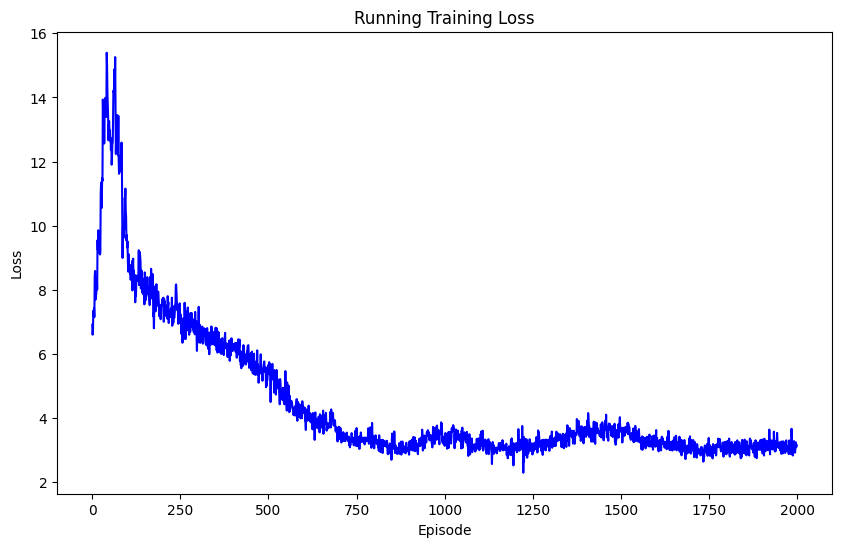

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title('Running Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
# plt.savefig('reward_becomes_complex_rewards.png')

In [57]:
memory.random_selected(2)

(tensor([[ 2.,  4.,  2.,  0.,  2.,  4.,  2.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,
           0.,  0.],
         [ 0.,  8.,  8.,  4.,  0.,  2., 16.,  8.,  0.,  0.,  4.,  4.,  0.,  0.,
           2.,  0.]]),
 tensor([1, 1]),
 tensor([  8., 124.]),
 tensor([[ 0.,  2.,  4.,  2.,  0.,  2.,  4.,  2.,  0.,  0.,  2.,  2.,  0.,  0.,
           0.,  2.],
         [ 0.,  0., 16.,  4.,  0.,  2., 16.,  8.,  2.,  0.,  0.,  8.,  0.,  0.,
           0.,  2.]]),
 tensor([False, False]))

Text(0, 0.5, 'Loss')

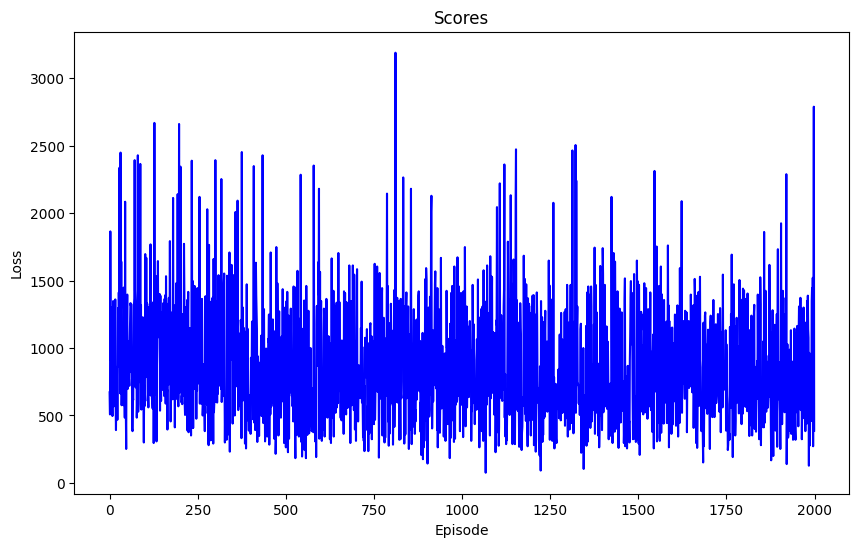

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(total_rewards, label='scores', color='blue')
plt.title('Scores')
plt.xlabel('Episode')
plt.ylabel('Loss')
# plt.savefig('reward_becomes_complex_rewards_score.png')

In [524]:
y_s

tensor([-1.3021e-01, -3.1168e-02,  5.2951e-01,  2.5302e-02,  3.1962e+01,
        -1.3523e-01, -3.7482e-01,  1.1876e+01,  3.9965e+00, -4.6202e-01,
         2.2982e-01, -2.6190e-01,  4.1729e+00, -4.3708e-01, -1.4040e-01,
         8.8312e-02])

In [490]:
y_s = r + gamma * torch.max(q_target(s_prime_s), axis=1).values
print(y_s.dtype)
y_s = torch.where(is_done_s, r_s, y_s)
print(y_s.dtype)

torch.float32


AttributeError: 'Tensor' object has no attribute 'astype'

In [527]:
loss

tensor(76.2785, grad_fn=<MseLossBackward0>)

In [491]:
r_s.dtype

torch.float64

In [483]:
y_s.dtype

torch.float64

In [485]:
s_prime_s.dtype

torch.float32

In [487]:
torch.max(q_target(s_prime_s), axis=1).values.dtype

torch.float32

In [473]:
s

tensor([[0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
        [0., 0., 0., 0., 2., 0., 0., 0

4.0

In [471]:
memory.memory_buffer

deque([(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.]),
        0,
        0,
        tensor([0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
        False),
       (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0.]),
        1,
        0,
        tensor([0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 4., 0., 0., 0., 0.]),
        False),
       (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0.]),
        3,
        0,
        tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
        False),
       (tensor([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
        3,
        0,
        tensor([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.]),
        False),
       (tensor([[0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
                [0., 0., 0.,

In [450]:
y_s

tensor([0.2249, 0.2249, 0.2249, 0.2249, 0.2249, 0.2249, 0.2249, 0.2249, 0.2249,
        0.2249, 0.2249, 0.2249, 0.2249, 0.2249, 0.2249, 0.2249],
       grad_fn=<WhereBackward0>)

In [449]:
q_scores

tensor([[-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062],
        [-0.0062]], grad_fn=<GatherBackward0>)

In [432]:
y_online = q_network(s)
y_online

tensor([[-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062],
        [-0.1081, -0.1041, -0.0063, -0.0062]], grad_fn=<AddmmBackward0>)

In [435]:
y_online.shape

torch.Size([16, 4])

In [441]:
torch.max(q_target(s_prime))

tensor(0.2427, grad_fn=<MaxBackward1>)

tensor([[-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063],
        [-0.0063]], grad_fn=<GatherBackward0>)

In [429]:
s, a, r, s_prime, is_done = memory.random_selected(mini_batch)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [430]:
a

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [415]:
y_s = torch.max(q_target(s_prime), axis=1).values
y_s = torch.where(is_done, r, y_s)

In [414]:
r[0] = 100
is_done[0] = 100

In [416]:
y_s

tensor([100.0000,   0.2078,   0.2078,   0.2078,   0.2078,   0.2078,   0.2078,
          0.2078,   0.2078,   0.2078,   0.2078,   0.2078,   0.2078,   0.2078,
          0.2078,   0.2078], grad_fn=<WhereBackward0>)

In [399]:
q_target(s_prime)

tensor([[0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467],
        [0.0744, 0.2078, 0.1677, 0.1467]], grad_fn=<AddmmBackward0>)

In [402]:
torch.max(q_target(s_prime), axis=1)

torch.return_types.max(
values=tensor([0.2078, 0.2078, 0.2078, 0.2078, 0.2078, 0.2078, 0.2078, 0.2078, 0.2078,
        0.2078, 0.2078, 0.2078, 0.2078, 0.2078, 0.2078, 0.2078],
       grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [338]:
q_target(torch[])

NameError: name 'experience' is not defined

In [344]:
memory.random_selected(mini_batch)

([tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([0.

In [312]:
loss(torch.tensor([1, 2]), torch.tensor([1.2, 2.2]))

tensor(0.0400)

In [247]:
s_prime

array([[0., 4., 0., 0.],
       [0., 0., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [248]:
reward

0

In [249]:
is_done

False

In [240]:
torch.argmax(q_target(s))

tensor(1)

In [241]:
q_target(s)

tensor([0.0594, 0.2296, 0.1675, 0.1340], grad_fn=<ViewBackward0>)

In [213]:
memory_buffer.append(1)
memory_buffer.append(2)
memory_buffer.append(3)

In [217]:
memory_buffer[0]

2

In [216]:
len(memory_buffer)

2